# Run the following cells to load the Lagator model."

### Action required: update these directories

In [5]:
# Model folder
model_path = '/mnt/c/users/timot/desktop/lagator/Brickplot_from_seq/Thermoters-master/'

# Fasta file with sequences
input_fasta_filepath = '/mnt/c/users/timot/desktop/lagator/Brickplot_from_seq/Input/v1.fasta'

# Output folder
output_folder = model_path + '/mnt/c/users/timot/desktop/lagator/Brickplot_from_seq/Output/'

### Parameters and preprocessing

In [4]:
import os
print(os.getcwd())
os.chdir(model_path + 'functions/')

/mnt/c/users/timot/desktop/lagator/Brickplot_from_seq/Thermoters-master/notebooks


In [6]:
# %%file setup.py
from setuptools import setup
from Cython.Build import cythonize
import numpy as np
import os
import Cython

print(np.get_include())

# os.environ["C_INCLUDE_PATH"] = np.get_include()
# setup(
#     ext_modules = cythonize(model_path +'functions/fastFunctions.pyx')
# )

/home/fuqua/.local/lib/python3.10/site-packages/numpy/core/include


In [7]:
from Bio import SeqIO
from Bio.Seq import Seq
from __future__ import division, print_function, absolute_import
import os
import numpy as np
import copy
from sys import path as syspath
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn import linear_model
import sklearn

In [8]:
os.chdir(model_path+'functions/fastFunctions_source')
os.getcwd()

'/mnt/c/users/timot/desktop/lagator/Brickplot_from_seq/Thermoters-master/functions/fastFunctions_source'

In [ ]:
!python3 setup_ubuntu.py build_ext --inplace

In [10]:
os.chdir(model_path+'notebooks/')
os.getcwd()
syspath.append(model_path+'data/')
syspath.append(model_path+'functions/')
os.getcwd()


from fastFunctions import bindingEnergies, getDiNu, tensum

# this imports the data and functions from definitions
#exec(open(model_path+"functions/definitions_bigfit_10.py").read())
exec(open(model_path+"functions/definitions_bigfit_10.py_deprecated").read())

In [11]:
bases = "acgt"
lett_to_index = dict(zip(bases, range(4)))

## Display options (adjusted to Mac)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
is_plus_one = True # True - a brick points to +1; False - points to -40
if is_plus_one: # shift for sequence to adjust +1 or -40
    shift = 40
else:
    shift = 0
    
is_reverse_complement = False # If True, reverse complement fasta seqs, then treat as usual

# For visualisation

max_value = -2.5
min_value = -6

is_high_to_default = False # If True, visualize brickplot values > treshold as default value
treshold = -2.5
default_value = max_value 
color_map = 'hot'

is_prefix_suffix = True # True - add Gs to the begining and end of each sequence to make it equal length and space for matrix

In [13]:
# Import promoters seqs data
fasta_reader = open(input_fasta_filepath, 'r')

# Initial sequences: fasta -> dict
dict_seqs = {}
max_seq_len = 0
for line in fasta_reader:
    if line.startswith('>'):
        seq_id = line.strip('>').strip()
        print(seq_id)
    else:
        seq = line.strip('"').strip()
        if seq == '':
            continue
        else:
            if is_reverse_complement:
                seq = str(Seq(seq).reverse_complement())
        print('sequence length = '+str(len(seq)))
        if max_seq_len < len(seq):
            max_seq_len = len(seq)
        print(seq)
        dict_seqs[seq_id] = seq
        
fasta_reader.close()

# Sequences unified by length (TO MODIFY?)
# Add artificial 'g's in the begining and the end of all sequences to mak ethem equal by length
unified_seqs_dict = {}
for seq_id in dict_seqs:
    seq = dict_seqs[seq_id]
    if is_prefix_suffix:
        prefix = str('g'*(max_seq_len - len(seq)+shift+5))
        suffix = str('g'*(32+2+shift))
        unified_seqs_dict[seq_id] = (prefix+seq+suffix).lower()
    else:
        unified_seqs_dict[seq_id] = seq.lower()
        
    #print(len(unified_seqs_dict[seq_id]))
        
# Seqs as numbers: 1) list of Int arrays made from Sequences unified by length, 2) list of seq_ids     
num_unified_seqs = []
seq_ids = []
for seq_id in unified_seqs_dict:
    seq_ids.append(seq_id)
    
num_unified_seqs = np.array([np.array([lett_to_index[l] for l in s]) for s in unified_seqs_dict.values()])

# Change so compatible with cython
num_unified_seqs = np.array(num_unified_seqs, dtype=np.int8)  # Make sure this is int8

v1
sequence length = 291
CGCCAGCAACCGCACCTGTGGCGCCGGTGATGCCGGCCACGATGCGTCCGGCGTAGAGGATCTGCTCATGTTTGACAGCTTATCATCGATAGCTAACAATTCGTTCAAGCCGAGCCCGCTTTGCGGTCTCGGACCGACCGGAGCCGCATCGGGCGGGCCGGCTTAACTCAGGCGTTAGGTTTGCATAAAATTTACGGTTCTAGGGTTTATGCTGAGAGAAGAGAGAGGCGAGCCTGCTGTTATGATACTTGTGAAGGGCGGCACTCTGTCGTCTAATTCTAGTTAGACATC


### Import the model

In [14]:
print(model_path)

/mnt/c/users/timot/desktop/lagator/Brickplot_from_seq/Thermoters-master/


In [ ]:
# Import the model
dmp_path = model_path + "models/fitted_on_Pr.Pl.36N/model_[2]_stm+flex+cumul.dmp"
print(dmp_path)
with open(dmp_path,"rb") as f:
    model = pickle.load(f, encoding="latin1")

In [16]:
leftFoot, rightFoot = model["matrices"]
defaultSpacer       = model["Layout"][1]
spacerFlexibility   = model["spFlex"]
spacerPenalties     = model["sp.penalties"]

# the total footprint of RNAp
print('The total footprint of RNAp = '+str(sum(model["Layout"])))

The total footprint of RNAp = 32


In [17]:
matrix = np.vstack([
    leftFoot,
    np.ones((defaultSpacer,4))*np.nan,
    rightFoot
])

print('The matrix size = '+str(matrix.shape))

The matrix size = (32, 4)


The matrix itself:
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
          nan         nan         nan         nan         nan         nan
          nan         nan  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.67076759 -0.29309879  0.79375497  1.53957    -0.95386856  1.69613292
  -1.800276    1.43133282  0.37573576  0.35488023 -0.25274799  0.05524443
          nan         nan         nan         nan         nan         nan
          nan         nan -0.08365061  0.71316041  0.09903286  0.09685599
  -0.28588    -1.14513958  5.98258833  0.13406241  1.91753541  0.85337357
   0.38857215  0.79529461]
 [ 0.26970059 -0.06229718 -0.42418894  0.17053728 -5.75540161  4.08121762
   0.49754882  1.32080299  0.53275453  0.47147459  0.05417641 -0.09901183
          nan         nan         nan         nan         nan         n

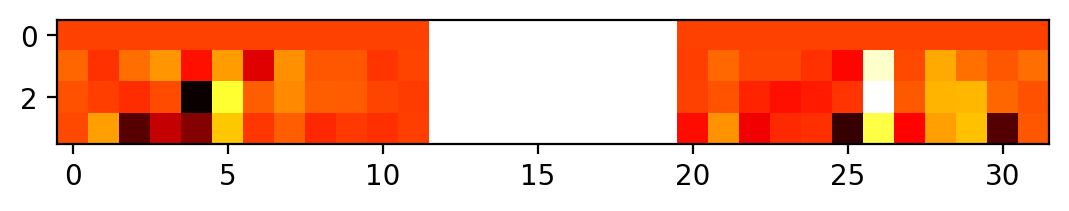

In [18]:
plt.imshow(matrix.T, cmap=color_map);
print('The matrix itself:')

#plt.savefig("lagator_heatmap.pdf")

print(matrix.T)

In [19]:
print(type(leftFoot[0][0]))
print(type(rightFoot[0][0]))
print(type(defaultSpacer))
print(type(spacerFlexibility))
print(type(spacerPenalties[0]))
print(type(num_unified_seqs[0][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'int'>
<class 'numpy.float64'>
<class 'numpy.int8'>


### Create "brickplots"

In [21]:
bricks = getBricks(
    twoMatrices = [leftFoot,rightFoot],
    minSpacer = defaultSpacer-spacerFlexibility, # minimal spacer
    spacerPenalties = spacerPenalties,
    sequences = num_unified_seqs
)

# Default spacer corresponds to spacer flex = 0 on a brickplot
print('defaultSpacer = '+str(defaultSpacer))

defaultSpacer = 8


gggggcgccagcaaccgcacctgtggcgccggtgatgccggccacgatgcgtccggcgtagaggatctgctcatgtttgacagcttatcatcgatagctaacaattcgttcaagccgagcccgctttgcggtctcggaccgaccggagccgcatcgggcgggccggcttaactcaggcgttaggtttgcataaaatttacggttctagggtttatgctgagagaagagagaggcgagcctgctgttatgatacttgtgaagggcggcactctgtcgtctaattctagttagacatcggggggggggggggggggggggggggggggggggggggggg

extended seg_len = 337


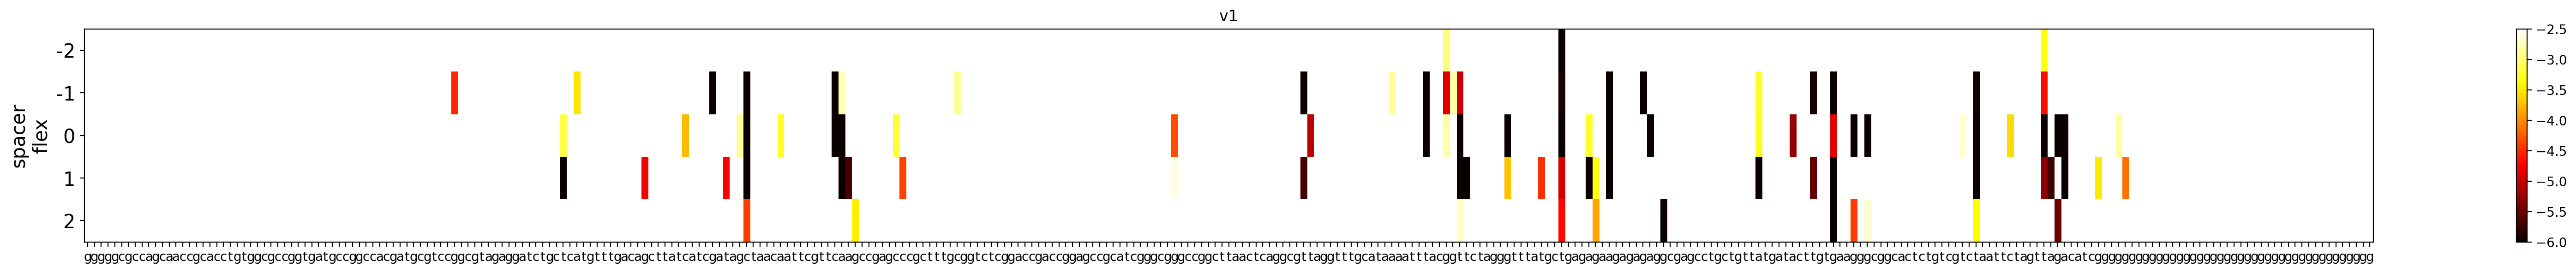

In [24]:
def remove_high_values(brick_in, treshold, default_value):
# Make values > treshold to be default value (for better visualization)
    brick_out = copy.deepcopy(brick_in)
    for i in range(brick_in.shape[0]):
        for j in range(brick_in.shape[1]):
            if brick_in[i,j] > treshold:
                brick_out[i,j] = default_value
    return brick_out
                
for i in range(len(num_unified_seqs)):
    curr_seq = unified_seqs_dict[seq_ids[i]][shift:-matrix.shape[0]-1]
    print(curr_seq)
    print('')
    print('extended seg_len = '+str(len(curr_seq)))
    theBrick = bricks.T[i]
    
    if is_high_to_default:
        theBrick_to_display = remove_high_values(theBrick, treshold, default_value)
    else:
        theBrick_to_display = theBrick

    plt.figure(figsize=(40,3))
    plt.imshow(theBrick_to_display.T[:,:theBrick_to_display.shape[0]-shift+1], cmap=color_map)
    plt.title(seq_ids[i])
    plt.yticks(range(5), np.arange(5)-2, fontsize=15)
    plt.xticks(range(len(curr_seq)), [char for char in curr_seq], fontsize=10)
    plt.clim([min_value,max_value])
    plt.ylabel('spacer\nflex', fontsize=15)
    plt.gca().set_aspect("auto")
    plt.colorbar()

In [25]:
def brick2lps(bricks_DNIs,
              fitpars,
              thresholdPosDict_ = None,
              bindMode_ = None,
              useChemPot = "chem.pot"
             ):
    
    out = {}               
    if thresholdPosDict_ is None: # No threshold position given
        thresholdPosDict_ = fitpars["ThDict"]
    if bindMode_ is None: # No bindMode given
        bindMode_ = fitpars["bindMode"]
    
    # Try to get clearance rate
    try:
        R_ = np.exp(fitpars["logClearanceRate"])
    except:
        R_ = None
    
    # Loop over bricks
    for dataID_ in bricks_DNIs:
        if "_rc" in dataID_: # Skip reverse complement?
            continue
        
        # Get binding energies
        bdni = bricks_DNIs[dataID_]
       
        # Get threshold position
        try:
            thresholdPos = thresholdPosDict_.get(dataID_, thresholdPosDict_["Prl"])
        except:
            for k in thresholdPosDict_:
                if dataID_ in k:
                    thresholdPos = thresholdPosDict_[k]
                    break
        if thresholdPos <= 0:
            thresholdPos = bdni.shape[1] + thresholdPos
        # If the bricks d n i
        off = thresholdPos < bdni.shape[1]
    
        # Handle bind mode
        if bindMode_ == "add":
            if R_ is None:
                bindF = lambda xi: -logsumexp(-xi, axis = tuple(range(1, xi.ndim)))
            else:
                bindF = lambda xi: -np.log(np.sum(
                                    1.0/(np.exp(xi) + R_),
                                    axis = tuple(range(1,xi.ndim))
                                            ))
        elif bindMode_ == "max":
            bindF = lambda xi: np.min(xi, axis = tuple(range(1, xi.ndim)))
        
        # 
        effON_ = bindF(bdni[:, :thresholdPos])
        if off:
            effOFF_ = bindF(bdni[:, thresholdPos:])
        else:
            effOFF_ = 0.
  # Reverse complement
        if dataID_ + "_rc" in bricks_DNIs:
            bdni_rc = bricks_DNIs[dataID_ + "_rc"]
            rcOcclusion = fitpars.get("rcOcclusion", np.arange(bdni_rc.shape[1]))
            effOFF_ += bindF(bdni_rc[:, rcOcclusion])
        Pons_ = np.exp(-effON_) / (1.0 + np.exp(-effON_) + np.exp(-effOFF_))
        out[dataID_] = np.log10(Pons_)
    
    return out

In [26]:
#print(bricks.T)
print(bricks.T.shape)
print((model["chem.pot"]))
chemPot = model["chem.pot"]["Pr.Pl"]
energyScale = model["en.scale"]
logPons = brick2lps({"Pr": energyScale*(bricks.T-chemPot)}, model)["Pr"]
print(type(logPons))
print('log(Pon) = '+str(logPons))
print('Pon = '+ str(10**logPons))

(1, 376, 5)
{'Pr.Pl': -17.908525893586578, '36N': -18.51051925714286}
<class 'numpy.ndarray'>
log(Pon) = [-0.47883907]
Pon = [0.33201746]


# A function to look for promoters in a given sequence using a sliding window:

In [32]:
def sliding_window_lagator(sequence, orientation, window_size):

    sequence = str(sequence).lower()
    if orientation == 'bottom':
        sequence = str(Seq(sequence).reverse_complement())
    if 'n' in sequence:
        pass
    else:
        
        probabilities = []
        for window_start in range(len(sequence)):
            cropped_sequence = sequence[window_start:window_start+window_size]
            if window_start + window_size <= len(sequence):
                #print(cropped_sequence)
    
                # Add 40 G's upstream and downstream of the sequence...
                cropped_sequence = 'gggggggggggggggggggggggggggggggggggggggg' + cropped_sequence + 'gggggggggggggggggggggggggggggggggggggggg'
    
                unified_seqs_dict = {}
                unified_seqs_dict['test'] = cropped_sequence
            
                # Process seqeunce for the brick plots     
                num_unified_seqs = []
                seq_ids = []
                for seq_id in unified_seqs_dict:
                    seq_ids.append(seq_id)  
                num_unified_seqs = np.array([np.array([lett_to_index[l] for l in s]) for s in unified_seqs_dict.values()])
                num_unified_seqs = np.array(num_unified_seqs, dtype=np.int8)  # Make sure this is int8
            
                # Calculate the promoters
                bricks = getBricks(twoMatrices = [leftFoot,rightFoot], minSpacer = defaultSpacer-spacerFlexibility, spacerPenalties = spacerPenalties, sequences = num_unified_seqs)
                theBrick = bricks.T
                chemPot = model["chem.pot"]["Pr.Pl"]
                energyScale = model["en.scale"]
                logPons = brick2lps({"Pr": energyScale*(bricks.T-chemPot)}, model)["Pr"]
                Pon = 10**logPons
    
                # Add to the list
                probabilities.append(float(Pon))

        #probabilities = list(probabilities)
        return probabilities

# Look for promoters on the 706 IS3s on the TOP strand
(This takes a while to run...)

In [52]:
probability_dictionary = {}
for record in SeqIO.parse("IS3_all.fasta", 'fasta'):
    sequence = record.seq
    probabilities = sliding_window_lagator(sequence, 'top', 36)
    probability_dictionary[record.id] = probabilities
print('done.')

done.


### Find promoters with score >= 0.5:

[ 85  48  45  17  24  10   9  34  10 131]


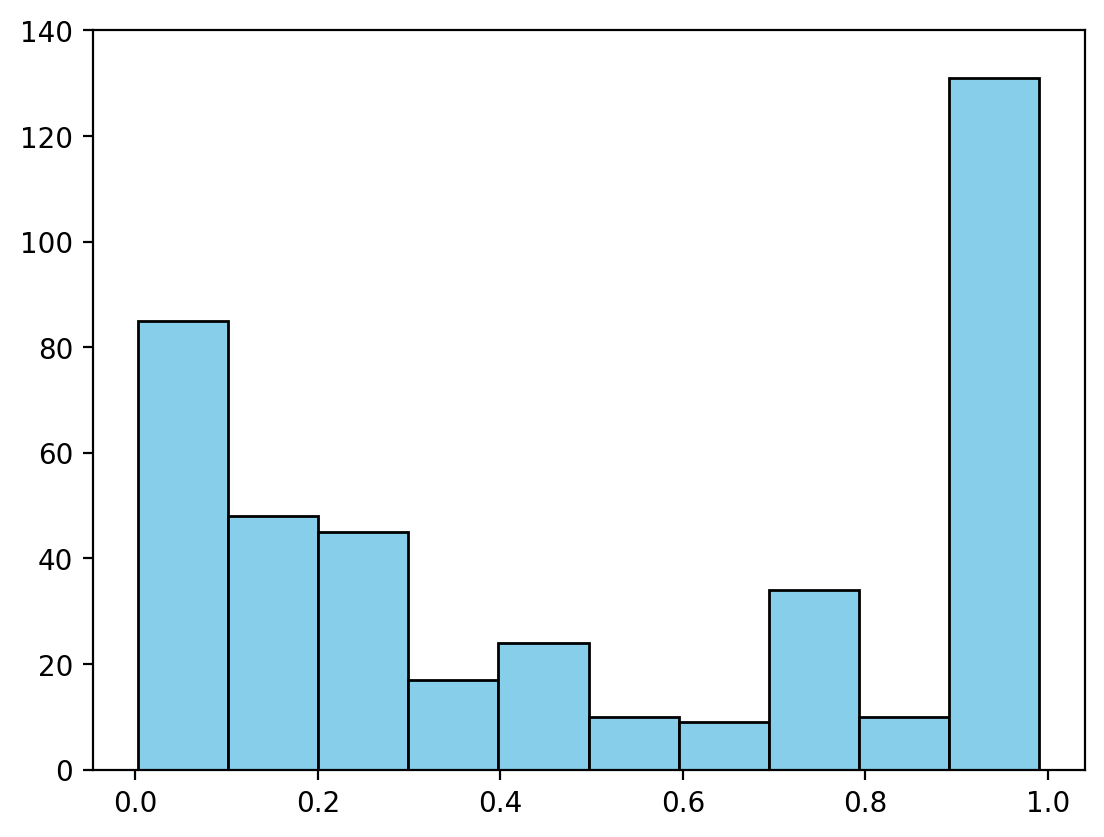

In [53]:
from scipy.signal import find_peaks

# A list of where promoter signatures are located across all the IS3s
positions = []
for key in dict.keys(probability_dictionary):
    probabilities = probability_dictionary[key]
    if probabilities is not None:

        # Locate peaks in the probabilities list
        indexes, properties = find_peaks(probabilities, height=0.5, distance=1)

        for index in indexes:
            positions.append(index/len(probabilities))

# Create histogram
plt.hist(positions, bins=10, color='skyblue', edgecolor='black')
plt.ylim(0,140)

counts, bin_edges = np.histogram(positions, bins=10)
print(counts)

### Find promoters with score >= 0.7

[51 26 37  2  7  5  3 15  1 69]


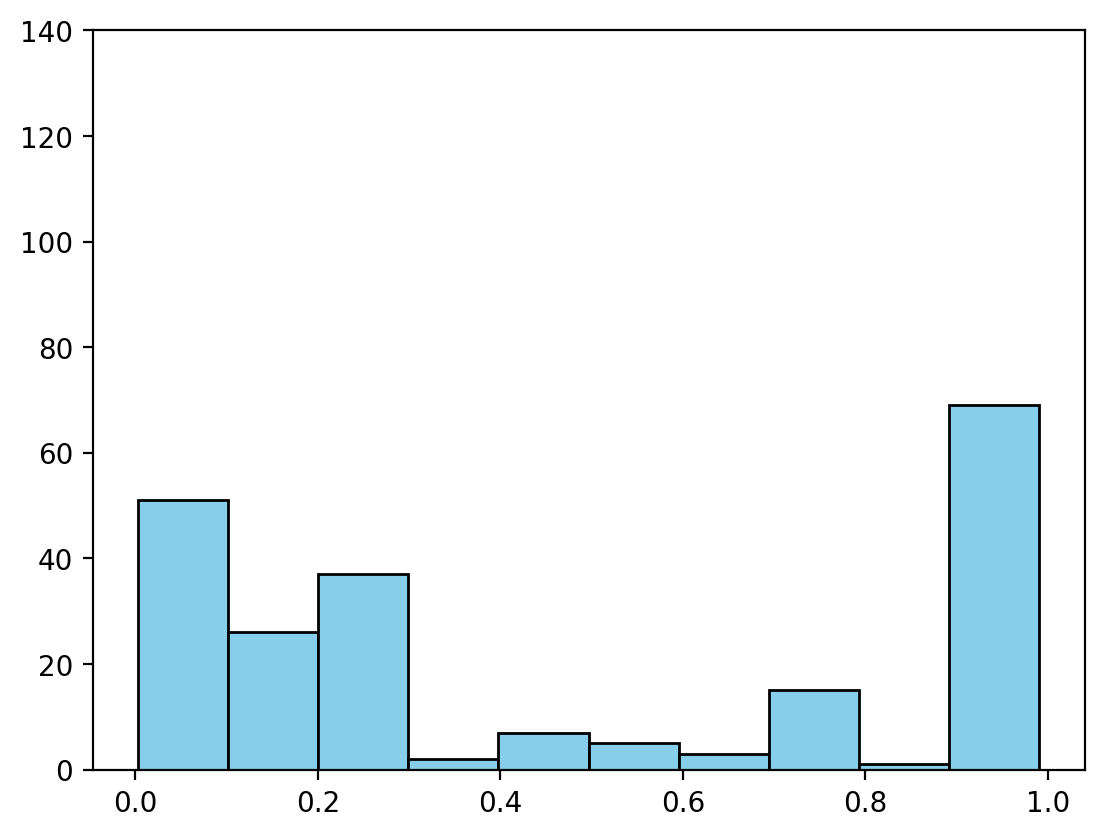

In [54]:
from scipy.signal import find_peaks

# A list of where promoter signatures are located across all the IS3s
positions = []
for key in dict.keys(probability_dictionary):
    probabilities = probability_dictionary[key]
    if probabilities is not None:

        # Locate peaks in the probabilities list
        indexes, properties = find_peaks(probabilities, height=0.7, distance=1)

        for index in indexes:
            positions.append(index/len(probabilities))

# Create histogram
plt.hist(positions, bins=10, color='skyblue', edgecolor='black')
plt.ylim(0,140)

counts, bin_edges = np.histogram(positions, bins=10)
print(counts)

### Find promoters with score >= 0.9

[26 10  2  0  2  3  0  0  0 33]


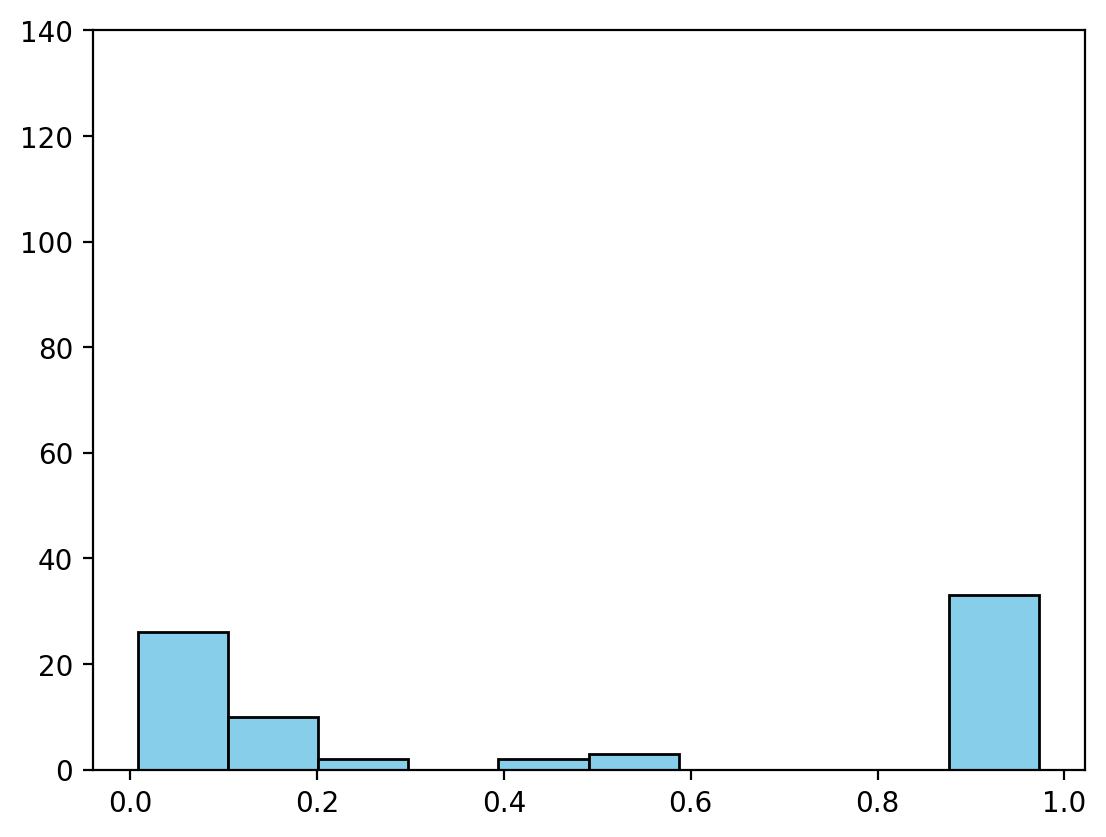

In [55]:
from scipy.signal import find_peaks

# A list of where promoter signatures are located across all the IS3s
positions = []
for key in dict.keys(probability_dictionary):
    probabilities = probability_dictionary[key]
    if probabilities is not None:

        # Locate peaks in the probabilities list
        indexes, properties = find_peaks(probabilities, height=0.9, distance=1)

        for index in indexes:
            positions.append(index/len(probabilities))

# Create histogram
plt.hist(positions, bins=10, color='skyblue', edgecolor='black')
plt.ylim(0,140)

counts, bin_edges = np.histogram(positions, bins=10)
print(counts)

# Look for promoters on the 706 IS3s on the BOTTOM strand

In [ ]:
probability_dictionary = {}
for record in SeqIO.parse("IS3_all.fasta", 'fasta'):
    sequence = record.seq
    probabilities = sliding_window_lagator(sequence, 'bottom', 36)
    probability_dictionary[record.id] = probabilities
print('done.')

### Find promoters with score >= 0.5:

In [ ]:
from scipy.signal import find_peaks

# A list of where promoter signatures are located across all the IS3s
positions = []
for key in dict.keys(probability_dictionary):
    probabilities = probability_dictionary[key]
    if probabilities is not None:

        # Locate peaks in the probabilities list
        indexes, properties = find_peaks(probabilities, height=0.5, distance=1)

        for index in indexes:
            positions.append(index/len(probabilities))

# Create histogram
plt.hist(positions, bins=10, color='indianred', edgecolor='black')
plt.ylim(0,140)

counts, bin_edges = np.histogram(positions, bins=10)
print(counts)

### Find promoters with score >= 0.7:

In [ ]:
from scipy.signal import find_peaks

# A list of where promoter signatures are located across all the IS3s
positions = []
for key in dict.keys(probability_dictionary):
    probabilities = probability_dictionary[key]
    if probabilities is not None:

        # Locate peaks in the probabilities list
        indexes, properties = find_peaks(probabilities, height=0.7, distance=1)

        for index in indexes:
            positions.append(index/len(probabilities))

# Create histogram
plt.hist(positions, bins=10, color='indianred', edgecolor='black')
plt.ylim(0,140)

counts, bin_edges = np.histogram(positions, bins=10)
print(counts)

### Find promoters with score >= 0.9:

In [ ]:
from scipy.signal import find_peaks

# A list of where promoter signatures are located across all the IS3s
positions = []
for key in dict.keys(probability_dictionary):
    probabilities = probability_dictionary[key]
    if probabilities is not None:

        # Locate peaks in the probabilities list
        indexes, properties = find_peaks(probabilities, height=0.9, distance=1)

        for index in indexes:
            positions.append(index/len(probabilities))

# Create histogram
plt.hist(positions, bins=10, color='indianred', edgecolor='black')
plt.ylim(0,140)

counts, bin_edges = np.histogram(positions, bins=10)
print(counts)